In [25]:
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score

import thesis_helper
functions = thesis_helper.Thesis_Helper()

from flair.embeddings import TransformerWordEmbeddings
from flair.data import Sentence

# init embedding
#embedding = TransformerWordEmbeddings('bert-base-uncased')
embedding = TransformerWordEmbeddings('Ivo/emscad-skill-extraction')

Some weights of the model checkpoint at Ivo/emscad-skill-extraction were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [26]:
annotations = '/Users//Datasources/Preprocessed/Combined/Taxonomy/Normal/Annotated/combined_annotations.csv'

In [27]:
df = pd.read_csv(annotations,sep=';')

#Filling any empty context columns with 'empty'
df['left_context'] = df['left_context'].fillna('empty')
df['right_context'] = df['right_context'].fillna('empty')

df['concatenated'] = df['left_context'] + ' | ' + df['candidate_skill'] + ' | ' + df['right_context']
print('Number of annotated rows ',df.shape[0])

Number of annotated rows  20836


In [28]:
def bert_embedder(text):

    string = Sentence(text)
    embedding.embed(string)

    # Creating a list which stores the indexes of the | symbols
    bar_indexes = []
    #Creating a list which stores the embedding_tensors
    embedding_tensors = []

    #Checking the sentence object for the | symbols and storing their indexes
    for x in range(1,len(string)+1):
        if '|' in str(string.get_token(x)):
            bar_indexes.append(x)

    #Collecting the embeddings for every index between the indexes in bar_indexes
    word_embedding_indexes = range(bar_indexes[0]+1,bar_indexes[1])
    for x in word_embedding_indexes:
        embedding_tensors.append(pd.Series(string[x].embedding))
        embedding_tensors.append(5)

    #Removing last 5 from list
    embedding_tensors.pop()

    #Turning the elements from embedding_tensors into dataframe rows
    row = pd.DataFrame()
    for x in range(0,len(embedding_tensors)):
        row = row.append(pd.DataFrame(pd.Series(embedding_tensors[x])))

    row = row.transpose().reset_index(drop=True)
    
    #Changing the column names in order to make pd.concat work later
    row.columns = [x for x in range(0,len(row.columns))]
    return row

In [29]:
df['embeddings'] = df['concatenated'].progress_apply(bert_embedder)

100%|██████████| 20836/20836 [29:50<00:00, 11.63it/s]


In [30]:
x_bert = pd.concat(df['embeddings'].tolist()).reset_index(drop=True)
x_bert = x_bert.fillna(0)
x_bert.head()

,0,1,2,3,4,5,6,7,8,9,...,3065,3066,3067,3068,3069,3070,3071,3072,3073,3074
0,0.264980,-1.062700,0.219049,-0.729541,0.651793,-0.323602,0.976396,0.691540,-0.670122,-1.090887,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.368794,-0.526832,-0.333102,-0.345097,0.702641,0.800185,0.755753,0.249978,0.180834,-0.033968,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.675702,-0.945983,-0.167887,-0.721513,0.841721,0.034037,1.301246,0.434035,0.080096,-0.048661,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.391995,-1.751309,0.115434,-0.762955,0.797096,-0.001810,0.853173,0.306305,0.023408,-0.997273,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.810415,-0.970256,-0.285407,-0.768392,1.189319,-0.353041,1.526766,0.729599,-0.005430,-0.943295,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# functions.store_object('bert_sequence_x', x_bert)
# functions.store_object('bert_sequence_y', df['label'])

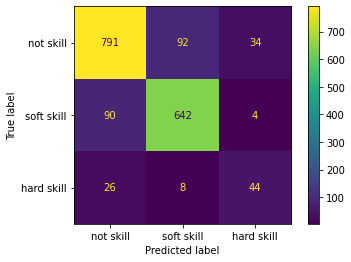

In [9]:
# model = LogisticRegression(solver='lbfgs', max_iter=10000000000000000000000,random_state=456, n_jobs=-1)

# x_train,x_test,y_train,y_test=train_test_split(x_bert, df['label'], test_size=0.2,random_state=456)
# model.fit(x_train,y_train)

# #Save confusion matrix best performing model
# from sklearn.metrics import classification_report, confusion_matrix
# from sklearn.model_selection import train_test_split
# import matplotlib.pyplot as plt
# from sklearn.metrics import plot_confusion_matrix

# plot_confusion_matrix(model.fit(x_train,y_train), x_test, y_test, display_labels=['not skill', 'soft skill', 'hard skill'])
# plt.savefig('confusion_matrix_conference_sequence_class_bert_lr.eps', format='eps')
# plt.show()

In [8]:
# %%time
# functions.model_performance(x_bert, df['label'])

In [31]:
df['pos'] = df['candidate_skill'].progress_apply(functions.pos_tagger)
df['pos'] = df['pos'].progress_apply(functions.sequence_counter)

pos_dicts = df[['pos']]
pos_dicts = pos_dicts['pos'].apply(pd.Series)
pos_dicts = pos_dicts.fillna(0).astype(int)

df['dep'] = df['candidate_skill'].progress_apply(functions.dep_tagger)
df['dep'] = df['dep'].progress_apply(functions.sequence_counter)

dep_dicts = df[['dep']]
dep_dicts = dep_dicts['dep'].apply(pd.Series)
dep_dicts = dep_dicts.fillna(0).astype(int)

x_pos = pos_dicts.join(dep_dicts,lsuffix='_gram', rsuffix='_pos')

x = x_bert.join(x_pos, lsuffix='_embedding', rsuffix='_pos')

100%|██████████| 20836/20836 [01:35<00:00, 218.50it/s]


In [33]:
df.columns

Index(['left_context', 'candidate_skill', 'right_context', 'label',
       'concatenated', 'embeddings', 'pos', 'dep'],
      dtype='object')

In [34]:
# functions.store_object('bert_sequence_x', x)
# functions.store_object('bert_sequence_y', df[['left_context', 'candidate_skill', 'right_context','label']])

In [10]:
%%time

functions.model_performance(x.fillna(0), df['label'])

  0%|          | 0/6 [00:00<?, ?it/s]

Starting model evaluation
We are at classifier  LogisticRegression(max_iter=10000000000000000000000, random_state=456)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 33.8min finished
 17%|█▋        | 1/6 [33:47<2:48:56, 2027.34s/it]

We are at classifier  GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=456)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 60.6min finished
 33%|███▎      | 2/6 [1:34:26<3:18:20, 2975.22s/it]

We are at classifier  SGDClassifier(random_state=456)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.5min finished
 50%|█████     | 3/6 [1:35:56<1:22:53, 1657.86s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


We are at classifier  RandomForestClassifier(random_state=456)


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  4.9min finished
 67%|██████▋   | 4/6 [1:40:49<37:18, 1119.08s/it]  [Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


We are at classifier  SVC(decision_function_shape='ovo', random_state=456)


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 24.3min finished
 83%|████████▎ | 5/6 [2:05:05<20:40, 1240.66s/it]

We are at classifier  MLPClassifier(alpha=1e-05, hidden_layer_sizes=(15,),
              max_iter=10000000000000000000000, random_state=456,
              solver='lbfgs')


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 19.4min finished
100%|██████████| 6/6 [2:24:28<00:00, 1444.78s/it]


CPU times: user 1.68 s, sys: 2.92 s, total: 4.6 s
Wall time: 2h 24min 29s


,Classifier,Precision,Recall,F1
0,LR,0.801670,0.787471,0.782443
1,GBC,0.764995,0.663556,0.689041
2,SGD,0.809853,0.777329,0.774928
3,RF,0.900056,0.573797,0.620707
4,SVM,0.883234,0.706934,0.744163
5,MLP,0.792364,0.783205,0.777376


In [ ]:
# x = x_bert
# x.head()

# x = x.head(100).fillna(0)
# y = df['label'].head(100)

In [20]:
from sklearn.model_selection import cross_validate
from statistics import mean
import numpy as np
from sklearn import svm
from sklearn.neural_network import MLPClassifier
model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=456)

x_bert = x_bert.astype(np.float64)

#Creating empty list to store the values
precision_scores=[]
recall_scores=[]
f1_scores=[]


performance_measures = ['precision_macro', 'recall_macro','f1_macro']
scores = cross_validate(model,x_bert, df['label'], scoring=performance_measures,cv=2,verbose=1, n_jobs=-1)

average_precision = mean(scores['test_precision_macro'])
average_recall = mean(scores['test_recall_macro'])
average_f1 = mean(scores['test_f1_macro'])

precision_scores.append(average_precision)
recall_scores.append(average_recall)
f1_scores.append(average_f1)

results = pd.DataFrame(zip(precision_scores,recall_scores,f1_scores),columns=['Precision', 'Recall', 'F1'])

results

#sgd
#lg
#GD
#RF

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: 

In [ ]:
functions.print(df.concatenated.iloc[0])

In [ ]:
functions.print(x.iloc[188])

In [ ]:
%%time
functions.model_performance(x, df['label'])

In [ ]:
functions.confusion_matrix(functions.LR,x.fillna(0), df['label'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['label']), df['label'], test_size=0.20, random_state=42)



#y_test['predictions'] = functions.LR.fit(X_train.fillna(0),y_train).predict(X_test)


In [ ]:
X_train = pd.concat(X_train['test'].tolist()).reset_index(drop=True)
X_train = X_train.fillna(0)

In [ ]:
X_test = pd.concat(X_test['test'].tolist()).reset_index(drop=True)
X_test = X_test.fillna(0)

In [ ]:
y_test['predictions'] = functions.LR.fit(X_train,y_train).predict(X_test)

In [ ]:
y_train['type'] = 'train'
y_test['type'] = 'test'

y = pd.concat([y_train,y_test])

In [ ]:
test = df.join(y_test,lsuffix='_echt', rsuffix='_pred')
test = test[['left_context','recovered_gram', 'right_context', 'label_echt', 'label_pred']]
test.to_csv('/Users//Desktop/test1000.csv')

In [ ]:
performance = df[['left_context', 'recovered_gram', 'right_context', 'label', 'predictions']]
performance

In [ ]:
performance[(performance.label==0) & (performance.predictions==1)].to_csv('/Users//Desktop/test5.csv')

In [ ]:
indexes = [1379411,
2837,
6853,
5332,
1379216,
          6161,6921]




In [ ]:

performance = performance.loc[indexes] 
#performance = performance.rename(columns={'focus_words':'candidate_skill'})


performance = performance.replace(0,'not skill')
performance = performance.replace(1,'soft skill')
performance = performance.replace(2,'hard skill')
performance

In [ ]:
import dataframe_image as dfi
dfi.export(performance,"Predictions.png")

In [ ]:
predictions = performance.loc[indexes]

In [ ]:
predictions = predictions.replace(0,'not skill')
predictions = predictions.replace(1,'soft skill')
predictions = predictions.replace(2,'hard skill')
predictions = predictions.rename(columns={'label': 'actual_label', 'predictions':'classifier_prediction'})
predictions